# Imports

In [2]:
#Imports
from modules.preamble import *
import json

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from skfuzzy import cmeans
from sklearn.cluster import KMeans

from modules.PFS import PFS_layer, PFS_CP
from modules.kappa import *

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Loading the data

In [6]:
#Load the data
df_train = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/df_train.hdf'))
df_val = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/df_val.hdf'))
df_test = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/df_test.hdf'))

X_train = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/X_train.hdf')).values
X_val = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/X_val.hdf')).values
X_test = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/X_test.hdf')).values

y_train = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/y_train.hdf')).values.ravel() #flat
y_val = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/y_val.hdf')).values.ravel()
y_test = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/y_test.hdf')).values.ravel()

instance_weights_train = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/instance_weights_train.hdf')).values.ravel()

## Comment w.r.t. class weight
Must (awkwardly) pass these as aggregated instance + class weights (multiply them) to tensorflow. Default interface offers no option to apply instance + class weights during training and only sample weights during testing (i.e. not possible when passing both arguments "class_weight" and "sample_weight"). Tested this awkward aspect extensively due to weird first results - pretty sure TF does not offer the feature we need out-of-the-box.

In [3]:
# Adjust sample weight in training w.r.t classes (i.e. multiply by class weight).

class_weights = compute_class_weight('balanced', [0,1], y_train) #Class weights as array
class_weights = {0: class_weights[0], 1: class_weights[1]} #Convert to dictionary

instance_class_weights_train = np.array(
    [sample_weight * class_weights[y] for sample_weight, y in zip(instance_weights_train, y_train)]
)

In [4]:
#Quick checking of data shapes to see if load was correct
print(df_train.shape, df_val.shape, df_test.shape)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)
print(instance_weights_train.shape)

(688457, 31) (117419, 31) (118967, 31)
(688457, 26) (117419, 26) (118967, 26)
(688457,) (117419,) (118967,)
(688457,)


# Generate the feature ranking based on information gain
Using the training dataset to avoid leakage between training & validation/testing sets

In [ ]:
#Runs in ~5 minutes.
from sklearn.feature_selection import mutual_info_classif
feat_colnames = df_train.columns[2:-3]
mi = mutual_info_classif(X_train, y_train, discrete_features=False)

df_mi = pd.DataFrame([mi, feat_colnames], 
                     index=['Mutual Information', 'Feature Name'],
                     columns=[i for i in range(len(feat_colnames))])
df_mi = df_mi.T.sort_values('Mutual Information', ascending=False)

In [6]:
df_mi

,Mutual Information,Feature Name
13,0.0563998,got(asat)
19,0.0546157,ptt
14,0.0512075,gpt(alat)
17,0.0474207,platelets
5,0.0397346,bilirubin
25,0.0358716,white blood cells
11,0.02928,fio2
2,0.0281018,arterial ph
12,0.0280517,glucose
24,0.028039,urea


Let's try a radically different number of neighbors. Does it exert an influence on the results?

In [6]:
#What happens if we change the number of neighbors?
#Runs in ~20 mins
mi = mutual_info_classif(X_train, y_train, discrete_features=False, n_neighbors=30) #10x as many neighbors as the default, which is 3

df_mi2 = pd.DataFrame([mi, feat_colnames], 
                     index=['Mutual Information', 'Feature Name'],
                     columns=[i for i in range(len(feat_colnames))])
df_mi2 = df_mi2.T.sort_values('Mutual Information', ascending=False)

In [7]:
#A bit different (lower values in general), though the top features remain quite intact
df_mi2

,Mutual Information,Feature Name
19,0.0524772,ptt
13,0.0524044,got(asat)
14,0.0473287,gpt(alat)
17,0.0461894,platelets
5,0.0376112,bilirubin
25,0.0343824,white blood cells
24,0.0272749,urea
12,0.026978,glucose
2,0.0250954,arterial ph
3,0.0240501,arterial po2


# Tuning

NB: Set the results to be stored as raw Python types, otherwise we seem to get issues w/ JSON writing.

In [7]:
#Setup
results = {}
filenr=1 #Alter filenames sometimes such that we have restore points in case the data gets corrupted
iteration = 0
index_to_feature_name = {index:feat_name for index, feat_name in enumerate(df_train.columns[2:28])}

Seems like fitting takes ~3 mins on average, but could be up to ~11 mins if the clustering & ML do not converge early.

In [8]:
#Automated tuning - stop this manually after your time budget has run out.
for n_features in range(1,8):
    for n_rules in range(2,8):
        #Update iteration nr, file number & seed
        iteration += 1
        np.random.seed(iteration)
        if (iteration%5 ==0):
            print(iteration)
            filenr += 1


        #store start time of the fit
        start_time = time.time()

        #Select the indexes of the features to include (in X), from the ranking on mutual information
        indices_sel_features = list(df_mi.iloc[:n_features].index.values)

        #Perform the clustering - either FCM or K-Means
#         cluster_centers,_,_,_,_,p,fpc = cmeans(X_train[:, indices_sel_features].T,
#                                              c=n_rules,
#                                              m=1.75,
#                                              error=0.005,
#                                              maxiter=1000,
#                                              seed=iteration)
        km = KMeans(n_clusters=n_rules, random_state=iteration, n_jobs=-1) #n_jobs=-1 for full CPU power
        km.fit(X_train[:, indices_sel_features], sample_weight = instance_class_weights_train)
        

        #PFS with SGD sometimes results in an error, because eq. (5) in Fialho and the
        #Normalization of membership function values can lead to division by 0
        try:
            #Setup the PFS with gradient descent
            model = tf.keras.Sequential()
            model.add(PFS_layer(X_train[:, indices_sel_features],
                                y_train,
                                km.cluster_centers_))

            model.compile(optimizer='Adam',
                          loss='binary_crossentropy',
                          metrics=[tf.keras.metrics.AUC(curve='ROC', name='ROC_AUC')])

            model.fit(X_train[:, indices_sel_features],
                      y_train,
                      sample_weight = instance_class_weights_train, #custom approach to include class weights here
                      validation_data=(X_val[:, indices_sel_features], y_val),
                      epochs=100,
                      batch_size=512,
                      verbose=0,
                      callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_ROC_AUC',
                                                                   mode='max',
                                                                   patience=5, 
                                                                   min_delta=0.005)])

            #Compute performance of the PFS-ML
            y_score = model.predict(X_val[:, indices_sel_features])
            roc_auc = roc_auc_score(y_val, y_score)
            auk = auk_score(y_val, y_score)

            #Store the configuration & output (to raw python types, otherwise issues w/ writing JSON)
            results[iteration] = {
                'n_features': n_features,
                'n_rules': n_rules,
                'roc_auc': roc_auc,
                'auk': auk,
                'error':False,
                'seed': iteration,
                'fitting_time (minutes)': (time.time() - start_time)/60
            }

            # with open(os.path.join(data_base_path, 'model_tuning', 'PFS-results-{}.json'.format(filenr)), 'w') as f:
            #     json.dump(results, f, indent=4)


        except tf.errors.InvalidArgumentError:
            #Catch exception if we got the 'division by zero' issue, which turns predictions into NaNs
            results[iteration] = {
                'n_features': n_features,
                'n_rules': n_rules,
                'error':True,
                'seed': iteration,
                'fitting_time (minutes)': (time.time() - start_time)/60
            }

            # with open(os.path.join(data_base_path, 'model_tuning', 'PFS-results-{}.json'.format(filenr)), 'w') as f:
            #     json.dump(results, f, indent=4)

C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


5


C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " remo

10


C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " remo

15


C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " remo

20


C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " remo

25


C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " remo

30


C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " remo

35


C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " remo

40


C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:968: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


# PFS model tuning analysis
The above was performed twice, once with FCM clustering and once with K-Means clustering.
The final two JSONs were manually renamed.

In [3]:
#Re-load results from storage
with open(os.path.join(data_base_path,'model_tuning/PFS-FCM-9.json'), 'r') as f:
    pfs_fcm_results = json.load(f)
    
with open(os.path.join(data_base_path,'model_tuning/PFS-KMeans-results-9.json'), 'r') as f:
    pfs_KMeans_results = json.load(f)

In [4]:
df_fcm = pd.DataFrame([pfs_fcm_results[i] for i in pfs_fcm_results.keys()]) #FCM clustering
df_km = pd.DataFrame([pfs_KMeans_results[i] for i in pfs_KMeans_results.keys()]) #KMeans clustering

In [5]:
#How many errors in both types?
df_fcm['roc_auc'].isnull().sum(), df_km['roc_auc'].isnull().sum(), 

(19, 0)

Thus, nearly 50% of the model fits using FCM clustering resulted in the zero-division error (probably because of extremely close cluster centers), but none of the fits using KMeans had this issue. Probably this is because FCM generates fuzzy clusters and KMeans crisp clusters?

In [9]:
#Let's inspect the errors
df_fcm[df_fcm['roc_auc'].isnull()]

,n_features,n_rules,roc_auc,auk,error,seed,cluster_n_iterations,cluster_fpc,fitting_time (minutes)
9,2,5,NaN,NaN,True,10,91,0.796390,2.057649
10,2,6,NaN,NaN,True,11,121,0.781839,2.467072
12,3,2,NaN,NaN,True,13,35,0.918978,1.118329
14,3,4,NaN,NaN,True,15,59,0.805780,1.775623
15,3,5,NaN,NaN,True,16,97,0.744385,2.005729
18,4,2,NaN,NaN,True,19,35,0.776476,0.876318
19,4,3,NaN,NaN,True,20,56,0.759130,1.343011
20,4,4,NaN,NaN,True,21,91,0.688680,2.149704
23,4,7,NaN,NaN,True,24,108,0.612358,2.449037
24,5,2,NaN,NaN,True,25,42,0.726936,0.877402


There does not seem to be a clear pattern as to when errors occur (e.g. many rules). This is somewhat surprising, as it would make sense if having more clusters is more likely to result in close cluster centers that overlap?

In [10]:
#Total fitting time
df_fcm['fitting_time (minutes)'].sum() + df_km['fitting_time (minutes)'].sum()

156.76897695859273

In [11]:
#Model performance statistics
df_fcm.describe()[['roc_auc', 'auk', 'cluster_n_iterations', 'cluster_fpc', 'fitting_time (minutes)']]

,roc_auc,auk,cluster_n_iterations,cluster_fpc,fitting_time (minutes)
count,23.000000,23.000000,42.000000,42.000000,42.000000
mean,0.610236,0.053338,96.404762,0.710989,2.151724
std,0.036847,0.017150,56.226918,0.181050,0.919151
min,0.566717,0.032845,29.000000,0.397288,0.876318
25%,0.582901,0.039649,60.250000,0.587570,1.495967
50%,0.599073,0.047556,88.000000,0.711928,2.031689
75%,0.628395,0.062898,118.500000,0.834108,2.462563
max,0.700212,0.093511,316.000000,0.997689,4.733964


In [12]:
#Model performance statistics
df_km.describe()[['roc_auc', 'auk', 'fitting_time (minutes)']]

,roc_auc,auk,fitting_time (minutes)
count,42.000000,42.000000,42.000000
mean,0.621963,0.058532,1.580871
std,0.041640,0.019908,0.277131
min,0.569250,0.033846,1.231530
25%,0.597851,0.045800,1.400150
50%,0.615563,0.054677,1.524114
75%,0.640351,0.068191,1.662591
max,0.709520,0.100370,2.598731


Generally, KMeans clustering seems to have slightly better model performance and lower model fitting times. Also, the best configuration was using KMeans. Let's inspect the to configurations:

In [13]:
df_km.sort_values('roc_auc', ascending=False)

,n_features,n_rules,roc_auc,auk,error,seed,fitting_time (minutes)
41,7,7,0.709520,0.100370,False,42,1.664260
38,7,4,0.708576,0.098856,False,39,1.625698
37,7,3,0.708088,0.098422,False,38,1.577406
39,7,5,0.707760,0.098125,False,40,1.632269
40,7,6,0.705404,0.098817,False,41,1.616611
36,7,2,0.702818,0.097444,False,37,1.233881
35,6,7,0.652360,0.073514,False,36,1.807629
30,6,2,0.650461,0.071224,False,31,1.231530
31,6,3,0.647231,0.070349,False,32,1.681847
34,6,6,0.645901,0.071729,False,35,1.796433


As expected, more features leads to higher performance on the ROC-AUC and the AUK. The best model is at the maximum amount of allowed complexity - 7 features & 7 rules. However, we can get nearly the same model performance with 7 features and only 4 rules. Thus, we choose the model with 7 features and 4 rules as the optimal model.

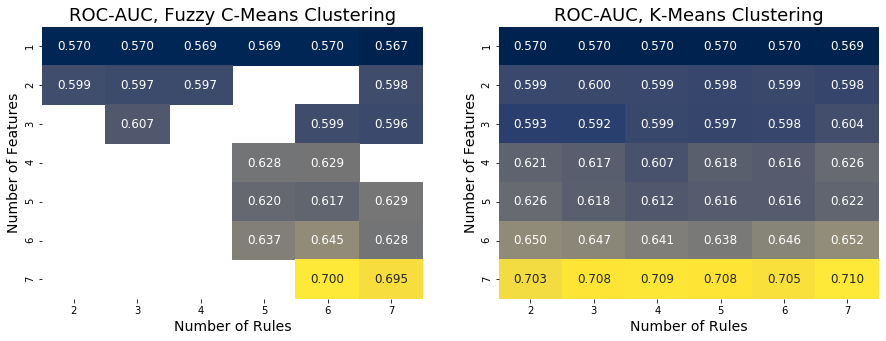

In [57]:
#Heatmaps
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.heatmap(df_fcm.pivot('n_features', 'n_rules', 'roc_auc'), 
            cmap='cividis',
            fmt='.3f', 
            annot=True, 
            annot_kws={'fontsize':12},
            ax=ax[0], 
            cbar=False);

sns.heatmap(df_km.pivot('n_features', 'n_rules', 'roc_auc'),
            cmap='cividis',
            fmt='.3f', 
            annot=True, 
            annot_kws={'fontsize':12},
            ax=ax[1],
            cbar=False);

ax[0].set_xlabel('Number of Rules', fontsize=14);
ax[1].set_xlabel('Number of Rules', fontsize=14);
ax[0].set_ylabel('Number of Features', fontsize=14);
ax[1].set_ylabel('Number of Features', fontsize=14);
ax[0].set_title('ROC-AUC, Fuzzy C-Means Clustering', fontsize=18);
ax[1].set_title('ROC-AUC, K-Means Clustering', fontsize=18);

# fig.savefig(os.path.join(figs_base_path, 'PFS-tuning-heatmap.png'),
#             dpi=200)

In [15]:
#Export best configs the hyperparameters of the best PFS models
# with open(os.path.join(data_base_path, 'model_tuning', 'Best-PFS-config.json'), 'w') as f:
#     best_pfs_config = {
#         'n_features': 7,
#         'feature_indices': [13, 19, 14, 17, 5, 25, 11],
#         'feature_names': ['got(asat)', 'ptt', 'gpt(alat)', 'platelets', 'bilirubin', 'white blood cells', 'fio2'],
#         'n_rules': 4,
#         'seed': 39,
#         'cluster_type': 'k-means'
#     }
#     json.dump(best_pfs_config, f, indent=4)